### Import Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Packages

In [ ]:
!pip3 install pykalman
!pip3 install filterpy

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from collections import defaultdict
import collections
import math
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import pickle
import ast
from mpl_toolkits import mplot3d
from numpy.linalg import inv
from numpy import ma
import csv

### Get Frames from Video

In [4]:
# before running create folder called "frames" and get path for "trailfinal_compress.mp4" (in folder metrics > data)
# frames will be put into folder
vidcap = cv2.VideoCapture("/content/drive/Shared drives/Book_Reading_Analysis_Project/Participant Data/Leanne Collected/JRC/world.mp4")

count = 0
success,image = vidcap.read() 
while success and count < 5:
    cv2.imwrite('/content/frames/frame%d.jpg' % count, image)     # save frame as JPEG file      
    success,image = vidcap.read()
    count += 1
    # if count % 5000 == 0:
    #     print('DONE frame%d' %count)
    # #if count % 150 == 0:
    #     #cv2.imwrite("frame" +str(count)+ ".jpg", image)  ## save image to file 
    # if count >= 16346:
    #     break

    # count += 1

vidcap.release()
cv2.destroyAllWindows()

### Get Frame

(720, 1280, 3) uint8
[138 142  92]


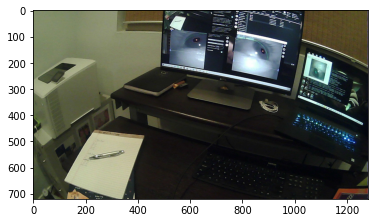

In [5]:
'''
    Function name: open_image
    Description: opens image and corrects it to the shape of the video frame (1280x720)
    Input: path to image
    Output: reshaped image
'''
def open_image(image_path):
  img = Image.open(image_path)
  shape_reference = cv2.imread('/content/frames/frame0.jpg')  # 'frames/frame290.jpg'
  out = img.resize((shape_reference.shape[1],shape_reference.shape[0]), Image.NEAREST)
  return out

test = open_image('/content/frames/frame0.jpg')  # 'frames/frame220.jpg'
imgplot2 = plt.imshow(test)
test = np.array(test)
print(test.shape, test.dtype)
print(test[0][0])

### Segment Label

In [35]:
# Segment Label

def connected_component(inp, cc_world_background, cc_page_background, cc_text, cc_figure, cc_caption):

    #out = [x.copy() for x in inp]
    m, n = len(inp), len(inp[0])
    out = [[0 for _ in range(n)] for _ in range(m)]
    visited = [[False for _ in range(n)] for _ in range(m)]
    
    def valid(i, j, ori):
        if i < 0 or i >= m or j < 0 or j >= n or inp[i][j] != ori:
            return False
        else:
            return True

    def bfs(i, j, index, ori, cc):
        check = False
        q = collections.deque()
        diffs = [(0,1), (1,0), (0,-1), (-1,0)]
        q.append((i, j))
        while q:
            current = q.popleft()
            x, y = current
            if visited[x][y]:
              continue
            if inp[x][y] != cc:
              continue
            visited[x][y] = True
            out[x][y] = index
            check = True
            for diff in diffs:
                neighbor = tuple([a + b for a, b in zip(current, diff)])
                if valid(neighbor[0], neighbor[1], ori):
                    q.append(neighbor)
        if check:
          return True
        return False

    tag_index = 2
    
    # find connected components for text boxes
    for i in range(m):
        for j in range(n):
            if not visited[i][j]:
                if inp[i][j] == cc_world_background:
                    out[i][j] = 0
                elif inp[i][j] == cc_page_background:
                    out[i][j] = 1
                else:
                    a = bfs(i, j, tag_index, inp[i][j], cc_text)
                    if a:
                      #text.append(tag_index)
                      tag_index += 1

    # find connected components for figures
    for i in range(m):
        for j in range(n):
            if not visited[i][j]:
                if inp[i][j] == cc_world_background:
                    out[i][j] = 0
                elif inp[i][j] == cc_page_background:
                    out[i][j] = 1
                else:
                    a = bfs(i, j, tag_index, inp[i][j], cc_figure)
                    if a:
                      #figure.append(tag_index)
                      tag_index += 1

    # find connected components for captions
    for i in range(m):
        for j in range(n):
            if not visited[i][j]:
                if inp[i][j] == cc_world_background:
                    out[i][j] = 0
                elif inp[i][j] == cc_page_background:
                    out[i][j] = 1
                else:
                    a = bfs(i, j, tag_index, inp[i][j], cc_caption)
                    if a:
                      #caption.append(tag_index)
                      tag_index += 1

    print(tag_index)
    return np.array(out)

### Show Labeling

29


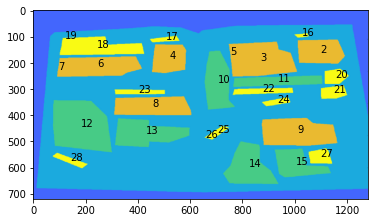

In [36]:
seg = open_image('/content/seg_b10_p78.png')
seg_array = np.array(seg)
m, n = len(seg_array), len(seg_array[0])
encoded = [[seg_array[i,j,0]*256*256 + seg_array[i,j,1]*256 + seg_array[i,j,2] for j in range(n)] for i in range(m)]

# order -> (encoded image, world background, page background, text, figure, caption)

# math book
labeled_output = connected_component(encoded, int("4366fd", 16), int("1baade", 16), int("eaba30", 16), int("47cb86", 16), int("f9fa14", 16))

# dna book
#labeled_output = connected_component(encoded, int("3e26a8", 16), int("337afd", 16), int("c8c129", 16), int("14beb8", 16), int("f9fb15", 16))

# label -> list of coordinates
show = labeled_output
points = defaultdict(list)
for i in range(len(show)):
    for j in range(len(show[i])):
        points[show[i][j]].append((i, j))

plt.imshow(seg_array)

for label, s in points.items():
    if label not in [0, 1]:
        mid = np.mean(s, axis=0)
        plt.annotate(str(label), xy=(mid[1], mid[0]))

In [40]:
# check correctness of labelling
for y in range(720):
  for x in range(1280):
    if labeled_output[y][x] == 19:
      print(y,x,labeled_output[y][x])

106 122 19
106 123 19


### Kalman Filtering

In [ ]:
from pykalman import KalmanFilter
import filterpy.kalman

def kalman_filter(name):
  data = pd.read_csv(name+'gaze_positions_smoothed.csv') 
  print(data.columns)
  xy = data[["norm_pos_x", "norm_pos_y"]].values
  xy = ma.asarray(xy)
  kf = KalmanFilter(initial_state_mean=[1,1.5],n_dim_obs=2)

  start=0
  stop=len(xy)

  for i in range(1,stop):
      if ((xy[i,0]>1) or (xy[i,0]<0) or (xy[i,1]>1) or (xy[i,1]<0) or(abs(xy[i,0]-xy[i-1,0])>50/1280) or (abs(xy[i,1]-xy[i-1,1])>30/720)):
          xy[i,0] = ma.masked
          xy[i,1] = ma.masked
          a = 0
          
  kf = kf.em(xy[start:stop], n_iter=5)
  (filtered_state_means, filtered_state_covariances) = kf.filter(xy[start:stop])
  (xy_new, smoothed_state_covariances) = kf.smooth(xy[start:stop])
  x_pred = xy_new[:,0]
  y_pred = xy_new[:,1]

  t = data["gaze_timestamp"]
  w_ind = np.asarray(list(map(int,data['world_index'])))
  conf = data["confidence"]

  with open(name + 'gaze_positions_filtered.csv', 'w') as f:
      f.write('gaze_timestamp,world_index,confidence,norm_pos_x,norm_pos_y\n')
      np.savetxt(f, np.column_stack((t, w_ind, conf, xy_new)), delimiter = ",", fmt = '%s')

### Extract CSV File Data

In [ ]:
# GAZE DOT DATA

name = '/content/drive/Shared drives/Book_Reading_Analysis_Project/Participant Data/Tawaana Collected/22_Male/003/exports/000/'
data = pd.read_csv(name+'gaze_positions.csv')  # Import gaze data as a numpy array 
t = data["gaze_timestamp"]
w_ind = np.asarray(list(map(int,data['world_index'])))
conf = data["confidence"]
x = data["norm_pos_x"].values
y = data["norm_pos_y"].values
indices = [ind for ind,value in enumerate(conf) if value < 0.75]
for ind in indices:
  if(ind>=0 and ind<x.shape[0]-1):
    x[ind] = (x[ind-1]+x[ind+1])/2
    y[ind] = (y[ind-1]+y[ind+1])/2
with open(name + 'gaze_positions_smoothed.csv', 'w') as f:
    f.write('gaze_timestamp,world_index,confidence,norm_pos_x,norm_pos_y\n')
    np.savetxt(f, np.column_stack((t, w_ind, conf, x, y)), delimiter = ",", fmt = '%s')
kalman_filter(name)
print("DONE")

Index(['gaze_timestamp', 'world_index', 'confidence', 'norm_pos_x',
       'norm_pos_y'],
      dtype='object')
DONE


In [ ]:
csv_gd = pd.read_csv('/content/drive/Shared drives/Book_Reading_Analysis_Project/Participant Data/Tawaana Collected/22_Male/003/exports/000/gaze_positions_filtered.csv')
index = csv_gd.iloc[:,1]   # index
confidence = csv_gd.iloc[:,2] # confidence
x = csv_gd.iloc[:,3] # x coord
y = csv_gd.iloc[:,4] # y coord

dot = [(int(index[i]),confidence[i], x[i], y[i]) for i in range(x.shape[0])]  # extract gaze data as coordinate

# DEBUG
print("GAZE DOT")
print("X SHAPE: %s" % x.shape)
print("Y SHAPE: %s" % y.shape)
print("LENGTH OF DOT ARRAY: %s" % len(dot))
print("COORD: %s" % str(dot[1]))

# IMAGE REGISTRATION DATA (HOMOGRAPHY MATRIX)

csv_ir = pd.read_csv('/content/drive/Shared drives/Book_Reading_Analysis_Project/Processed Image Registration/Tawaana Collected/Age_22/003/b22_p62-63.csv')
frame_number = csv_ir.iloc[:,0]   # frame
homography_matrix = csv_ir.iloc[:,1] # homographies
frame_info = [(frame_number[i], homography_matrix[i]) for i in range(len(frame_number))]

# DEBUG
print()
print("IMAGE REGISTRATION")
print("NUMBER OF FRAMES: %s" % frame_number.shape)
print("NUMBER OF HOMOGRAPHIES: %s" % homography_matrix.shape)
print(frame_info[0][1])

GAZE DOT
X SHAPE: 19888
Y SHAPE: 19888
LENGTH OF DOT ARRAY: 19888
COORD: (0, 0.9993161733909036, 0.3418115441568069, 0.710066861888547)

IMAGE REGISTRATION
NUMBER OF FRAMES: 2474
NUMBER OF HOMOGRAPHIES: 2474
[[ 6.65490317e-01  4.36822555e-01  2.16954126e+02]
 [ 5.54972417e-03  1.19960082e+00 -1.32821128e+02]
 [-1.49653553e-04  7.41172460e-04  1.00000000e+00]]


Index(['gaze_timestamp', 'world_index', 'confidence', 'norm_pos_x',
       'norm_pos_y'],
      dtype='object')


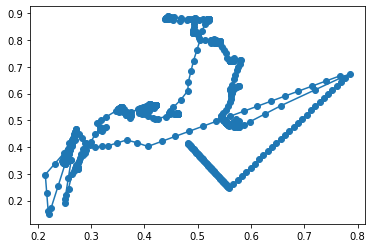

In [ ]:
data = pd.read_csv(name+'gaze_positions_filtered.csv')
print(data.columns)
t = data["gaze_timestamp"]
w_ind = np.asarray(list(map(int,data['world_index'])))
conf = data["confidence"]
x = data["norm_pos_x"].values
y = data["norm_pos_y"].values
plt.plot(x[220:1000],y[220:1000], marker='o')
plt.show()

### Get Reference Coordinate

In [ ]:
def coordinate(h_matrix, coord):
  x = coord[2] * 1280
  y = 720 - (coord[3] * 720)
  
  # manual shift for gaze dot
  # if coord[0] >= 339 and coord[0] <= 359: # seg 18
  #   x = x + 15
  #   y = y - 25
  # if coord[0] >= 360 and coord[0] <= 366: # seg 20
  #   x = x + 40
  # if coord[0] >= 370 and coord[0] <= 396: # seg 18
  #   x = x + 15
  #   y = y - 25  
  # if coord[0] >= 399 and coord[0] <= 463: # seg 19
  #   x = x + 20
  #   y = y - 50
  # if coord[0] >= 464 and coord[0] <= 528: # seg 9
  #   x = x + 30
  #   y = y + 15
  # if coord[0] >= 529 and coord[0] <= 582: # seg 19
  #   x = x + 20
  #   y = y - 50
  # if coord[0] >= 583 and coord[0] <= 612: # seg 9
  #   x = x + 30
  #   y = y + 15
  # if coord[0] >= 613 and coord[0] <= 712: # seg 19
  #   x = x + 20
  #   y = y - 50
  
  c_matrix = np.float32([x,y,1])

  # reformat h_matrix
  h_matrix = h_matrix.replace("\n", ",")
  h_matrix = h_matrix.replace("  ", ",")
  h_matrix = h_matrix.replace(" -", ",-")
  h_matrix = h_matrix.replace(" ", "")
  h_matrix = ast.literal_eval(h_matrix)
  
  h_inverse = np.linalg.inv(h_matrix)
  out = np.matmul(h_inverse, c_matrix)
  out = (int(out[0]), int(out[1]))
  return out

### Overlay output of inverse homography onto world view

In [ ]:
radius = 10
color = (255,0,0)
thickness = -1
count = 0

reference = cv2.imread('C:\\Users\\18587\\Desktop\\Book Reading Analysis Project\\Metrics\\frame0.jpg')
video = cv2.VideoWriter('C:\\Users\\18587\\Desktop\\inverse_homography_prot1.mp4', 0, 60, (reference.shape[1], reference.shape[0]))

for registration_frame_num in range(240): # iterate through frame_info csv array # len(frame_info)
    
  frame_num = frame_info[registration_frame_num][0]
  h_matrix = frame_info[registration_frame_num][1]
  #print(registration_frame_num)

  for coord in dot:
    if coord[0] == frame_num:

      reference_gaze_dot = coordinate(h_matrix, coord) # (x,y) position for reference image
      print(reference_gaze_dot)

      image = cv2.imread('C:\\Users\\18587\\Desktop\\Book Reading Analysis Project\\Metrics\\seg.png')
      image = cv2.resize(image, (reference.shape[1], reference.shape[0]))
      image = cv2.circle(image, reference_gaze_dot, radius, color, thickness)
      video.write(image)

video.release()

# Output - Metrics

### Time spent in each box & The fraction of distraction time (1,2)

In [ ]:
''' 
    Function name: time_box
    Description: calculates fraction of time spend in each segment
    Input: array of gaze dot positions (x,y) and homography of each frame
    Output: list the fraction of time spend in each frame
'''

gaze_dot_list = []

def time_box(gaze_data, registration_frame):

  for registration_frame_num in range(len(registration_frame)): # iterate through frame_info csv array
      
      frame_num = registration_frame[registration_frame_num][0]
      h_matrix = registration_frame[registration_frame_num][1]
      
      # print(registration_frame_num)
      #frame_num += 212

      for coord in gaze_data:
        if coord[0] == frame_num:

          reference_gaze_dot = coordinate(h_matrix, coord) # (x,y) position for reference image
          #print(type(reference_gaze_dot))
          reference_gaze_dot = list(reference_gaze_dot)

          if  1280 > reference_gaze_dot[0] > 0 and 720 > reference_gaze_dot[1] > 0:
            gaze_dot_list.append(reference_gaze_dot)

  seg = [labeled_output[int(y)][int(x)] for x, y in gaze_dot_list]
  # print(seg)
  print(type(seg))
  count = {}
  for d in seg:
      count[d] = count.get(d, 0) + 1
  print(count)
  sorted_count = sorted(count)
  print(sorted_count)

  fraction = {}
  nd = len(gaze_dot_list)
  for i in count:
      fraction[i] = count[i]/nd
  print(fraction)
  
  return fraction

# TESTS
frac_box = time_box(dot, frame_info)
print(frac_box)

  #for i in fraction:
      #time[i] = fraction[i]*(2*60+11)
  #print(time)

<class 'list'>
{16: 239, 12: 793, 1: 3698, 3: 677, 0: 1200, 5: 579, 22: 13, 11: 599, 14: 632, 21: 18, 9: 210, 6: 614, 10: 275, 4: 229, 8: 111, 13: 986, 15: 107, 23: 555, 2: 231, 7: 61, 24: 17, 18: 4}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 21, 22, 23, 24]
{16: 0.020172180958811615, 12: 0.06693112761647535, 1: 0.31212018906144495, 3: 0.05714044564483457, 0: 0.1012829169480081, 5: 0.04886900742741391, 22: 0.0010972316002700877, 11: 0.050557056043214046, 14: 0.053342336259284265, 21: 0.0015192437542201215, 9: 0.017724510465901417, 6: 0.051823092505064144, 10: 0.023210668467251856, 4: 0.019328156650911546, 8: 0.00936866981769075, 13: 0.08322079675894666, 15: 0.009031060094530722, 23: 0.04684334908845375, 2: 0.01949696151249156, 7: 0.005148548278190412, 24: 0.0014348413234301148, 18: 0.00033760972316002703}
{16: 0.020172180958811615, 12: 0.06693112761647535, 1: 0.31212018906144495, 3: 0.05714044564483457, 0: 0.1012829169480081, 5: 0.04886900742741391, 22: 0.0010972316

### Average Distance Between Gaze Dots

In [ ]:
''' 
    Function name: avg_distance
    Description: calculates average distance between gaze dots
    Input: array of gaze dot positions (x,y)
    Output: average distance float
'''
def avg_distance(gaze_data, min_confidence):
  
  length = len(gaze_data)
  distance = 0
  total_points_counted = 0
  #print("Length of gaze dot array: %s" % length)

  for position in range(length - 1):
    a = gaze_data[position][2] * 1280 # x coord at position
    b = gaze_data[position][3] * 720 # y coord at position
    c = gaze_data[position + 1][2] * 1280 # x coord at position + 1
    d = gaze_data[position + 1][3] * 720 # y coord at position + 1
    if gaze_data[position][1] > min_confidence and gaze_data[position + 1][1] > min_confidence and a < 1280 and b < 720 and c < 1280 and d < 720:
      distance += math.sqrt((a - c)**2 + (b - d)**2)
      total_points_counted += 1
  print(total_points_counted)
  return distance / total_points_counted

print("Average distance: %s" % round(avg_distance(dot, 0.0),2))

76049
Average distance: 95.82


In [ ]:
def segment_avg_distance(image, gaze_data, registration_frame):

  seg_info = [(0,0)] * 25
  
  for registration_frame_num in range(len(registration_frame)): # iterate through frame_info csv array
    
    frame_num = registration_frame[registration_frame_num][0]
    h_matrix = registration_frame[registration_frame_num][1]

    frame_num += 0
    print(registration_frame_num)

    for i in range(len(gaze_data) - 1):
      if gaze_data[i][0] == frame_num and gaze_data[i+1][0] == frame_num:

        try:
          reference_gaze_dot = coordinate(h_matrix, gaze_data[i]) # (x,y) position for reference image
          next_reference_gaze_dot = coordinate(h_matrix, gaze_data[i+1])
        
        except:
          print("no")
          continue
        
        # check if segment is the same
        if reference_gaze_dot[1] < 720 and next_reference_gaze_dot[1] < 720 and reference_gaze_dot[0] < 1280 and next_reference_gaze_dot[0] < 1280:
          if reference_gaze_dot[1] >= 0 and next_reference_gaze_dot[1] >= 0 and reference_gaze_dot[0] >= 0 and next_reference_gaze_dot[0] >= 0:
            a = image[reference_gaze_dot[1]][reference_gaze_dot[0]]
            b = image[next_reference_gaze_dot[1]][next_reference_gaze_dot[0]]

            # calculate distance
            if a == b:
              distance = math.sqrt((reference_gaze_dot[0] - next_reference_gaze_dot[0])**2 + (reference_gaze_dot[1] - next_reference_gaze_dot[1])**2)
              temp = list(seg_info[a])
              temp[0] += distance
              temp[1] += 1
              seg_info[a] = tuple(temp)

  print(seg_info)

  output = []
  for seg in seg_info:
    if seg[1] != 0:
      output.append(seg[0]/seg[1])
    else:
      output.append(0)
  return output

# TESTS
segment_avg_distance_output = segment_avg_distance(labeled_output, dot, frame_info)
print(segment_avg_distance_output)

### Calculate Total Area

In [ ]:
# Global Variables
output_length = 25

''' 
    Function name: total_area
    Description: calculates total area (# of pixels) for each segment
    Input: labeled_output, matrix of visited pixels
    Output: array of area for each segment number
'''
def total_area(labeled_output, pixel_data):
  
  total = [0] * output_length
  y_coord, x_coord = len(labeled_output), len(labeled_output[0])

  if pixel_data == None:
    for y in range(y_coord):
      for x in range(x_coord):
        segment = labeled_output[y][x]
        total[segment] = total[segment] + 1

  else:
    for y in range(y_coord):
      for x in range(x_coord):
        segment = labeled_output[y][x]
        if pixel_data[y][x] >= 1:
          total[segment] = total[segment] + 1

  return total

In [ ]:
def check_reread(labeled_output, pixel_data): # , segment_number (future -> automate)
  out_upper = [0] * 10
  out_lower = [0] * 10
  y_coord, x_coord = len(labeled_output), len(labeled_output[0])
  for y in range(y_coord):
    for x in range(x_coord):
      segment = labeled_output[y][x]
      number_of_visits = pixel_data[y][x]

      # overflow
      if number_of_visits >= 9:
        number_of_visits = 9

      # check segment
      if segment == 7:
        # upper half
        if y < 575:
          out_upper[number_of_visits] += 1
        # lower half
        else:
          out_lower[number_of_visits] += 1
  
  total_upper = 0
  two_plus = 0
  for i in range(len(out_upper)):
    total_upper += out_upper[i]
    if i > 1:
      two_plus += out_upper[i]
  
  percent_upper = two_plus / total_upper
  
  total_lower = 0
  for i in out_lower:
    total_lower += i
  
  percent_lower = out_lower[0] / total_lower

  if percent_upper > 0.5 and percent_lower > 0.8:
    for y in range(y_coord):
      for x in range(x_coord):
        segment = labeled_output[y][x]
        number_of_visits = pixel_data[y][x]

        # check segment
        if segment == 7:
          if y < 575:
            if number_of_visits > 1:
              pixel_data[y][x] -= 1
              pixel_data[y+50][x] += 1

  return (out_upper, out_lower, percent_upper, percent_lower)

### Percent Read Segment (3)

In [ ]:
def percent_read(image, gaze_data, registration_frame):

  total = total_area(image, None) # get area of reference

  diameter = math.floor(avg_distance(gaze_data, 0.0)) # get distance of gaze dots
  print("DIAMETER: %s" % diameter)
  # calculate radius
  if (diameter % 2) == 1:
    diameter = diameter + 1
  radius = int(diameter / 2)
  print("RADIUS: %s" % radius)

  width, height = 1280, 720; # x,y
  gaze_matrix = [[0 for x in range(width)] for y in range(height)] # matrix that counts how many times each pixel has been read

  for registration_frame_num in range(len(registration_frame)): # iterate through frame_info csv array
    
    frame_num = registration_frame[registration_frame_num][0]
    h_matrix = registration_frame[registration_frame_num][1]

    frame_num += 0
    print(registration_frame_num)

    for coord in gaze_data:
      if coord[0] == frame_num:

        try:
          reference_gaze_dot = coordinate(h_matrix, coord) # (x,y) position for reference image
        
        except:
          continue

        # if reference_gaze_dot[1] < 720 and reference_gaze_dot[0] < 1280:
        #   if reference_gaze_dot[1] and reference_gaze_dot[0] >= 0:
        #     seg_check = image[reference_gaze_dot[1]][reference_gaze_dot[0]]
        #     diameter = int(segment_avg_distance_output[seg_check])

            # # check re-read condition for segment 7
            # if seg_check == 7:
            #   if gaze_matrix[reference_gaze_dot[1]][reference_gaze_dot[0]] >= 1:
            #     temp = list(reference_gaze_dot)
            #     temp[1] += 50
            #     reference_gaze_dot = tuple(temp)
            
        for x in range(reference_gaze_dot[0] - diameter, reference_gaze_dot[0] + diameter):
          for y in range(reference_gaze_dot[1] - diameter, reference_gaze_dot[1] + diameter):
            if x > 0 and x < 1280 and y > 0 and y < 720:
              gaze_matrix[y][x] = gaze_matrix[y][x] + 1

  check_seven = check_reread(image, gaze_matrix)
  print(check_seven)
  
  total_gaze_area = total_area(image, gaze_matrix)

  output = [(0,0)] * output_length
  for index in range(len(output)):
    output_list = list(output[index])
    output_list[0] = index
    if total[index] != 0:
      output_list[1] = round((total_gaze_area[index] / total[index]) * 100, 2)
    output[index] = tuple(output_list)

  return output

# TESTS
out = percent_read(labeled_output, dot, frame_info)
print(out)

seg = []
p_read = []

for i in out:
  seg.append(i[0])
  p_read.append(i[1])

df = pd.DataFrame()
df['Segment Number'] = seg
df['Percent Read'] = p_read
df.to_csv('/content/drive/Shared drives/Book_Reading_Analysis_Project/Metrics/Data/JRC/repeat_diameter_b22_p10-11.csv')

### Percent Read Page (4)

In [ ]:
def total_read(image, gaze_data, registration_frame):

  total = total_area(image, None)
  diameter = math.floor(avg_distance(gaze_data, 0.0))

  if (diameter % 2) == 1:
    diameter = diameter + 1
  radius = int(diameter / 2)

  width, height = 1280, 720; # x,y
  gaze_matrix = [[0 for y in range(width)] for x in range(height)]

  for registration_frame_num in range(len(registration_frame)): # iterate through frame_info csv array
    
    frame_num = registration_frame[registration_frame_num][0]
    h_matrix = registration_frame[registration_frame_num][1]

    frame_num += 13369
    print(registration_frame_num)
    
    for coord in gaze_data:
      if coord[0] == frame_num:

        try:
          reference_gaze_dot = coordinate(h_matrix, coord) # (x,y) position for reference image
        
        except:
          continue

        for x in range(reference_gaze_dot[0] - diameter, reference_gaze_dot[0] + diameter):
          for y in range(reference_gaze_dot[1] - diameter, reference_gaze_dot[1] + diameter):
            if x > 0 and x < 1280 and y > 0 and y < 720:
              gaze_matrix[y][x] = gaze_matrix[y][x] + 1
   
  total_gaze_area = total_area(image, gaze_matrix)

  segment_area = 0
  segment_gaze_area = 0

  for index in range(1, output_length): # don't count segment 0 and 1
    segment_area += total[index]
    segment_gaze_area += total_gaze_area[index]

  print(segment_gaze_area)
  print(segment_area)
  output = (segment_gaze_area / segment_area) * 100

  return output

# TESTS
print(round(total_read(labeled_output, dot, frame_info),2))

### Segment within Gaze Dot Radius

In [ ]:
def segments_within_circle(cc, center, radius):
    """ 
    Consider machine accuracy and compute segments each dot cover.
    Args:
        cc: matrix of segmented pixels
        center: gaze dot positions, a list of tuple (x, y).
        radius: machine accuracy(pixels).
    Returns:
        segments: the set of covering segments for each gaze dot.
    """
    segments = set()
    ir = int(radius) # + 0.5
    for i in range(-ir, ir + 1):
        for j in range(-ir, ir + 1):
            if i * i + j * j <= radius * radius:
                if int(center[0] + i) > 0 and int(center[0] + i) < 720 :
                    if  int(center[1] + j) > 0 and  int(center[1] + j) < 1280 :
                        segments.add(cc[int(center[0] + i), int(center[1] + j)])
                # print(segments)
    return segments


### Needleman-Wunsch and Smith-Waterman Algorithms

In [ ]:
def zeros(shape):
    retval = []
    for x in range(shape[0]):
        retval.append([])
        for y in range(shape[1]):
            retval[-1].append(0)
    return retval

match_award      = 10
mismatch_penalty = -10
gap_penalty      = -5

def match_score(alpha, beta):
    if alpha == beta:
        return match_award
    elif alpha == '-' or beta == '-':
        return gap_penalty
    else:
        return mismatch_penalty

def finalize(align1, align2):
    align1 = align1[::-1]    #reverse sequence 1
    align2 = align2[::-1]    #reverse sequence 2
    
    i,j = 0,0
    
    #calcuate identity, score and aligned sequeces
    symbol = []
    found = 0
    score = 0
    identity = 0
    for i in range(0,len(align1)):
        # if two AAs are the same, then output the letter
        if align1[i] == align2[i]:                
            symbol.append(align1[i])
            identity = identity + 1
            score += match_score(align1[i], align2[i])
    
        # if they are not identical and none of them is gap
        elif align1[i] != align2[i] and align1[i] != '-' and align2[i] != '-': 
            score += match_score(align1[i], align2[i])
            symbol.append(' ')
            found = 0
    
        #if one of them is a gap, output a space
        elif align1[i] == '-' or align2[i] == '-':          
            symbol.append(' ')
            score += gap_penalty
    
    identity = float(identity) / len(align1) * 100
    
    print('Identity =', "%3.3f" % identity, 'percent')
    print('Score =', score)
    print('Ground Truth = ', align1)
    print('Run Length Test Order = ', align2)
    print('Matches = ', symbol)
    return score, align1, align2, symbol


def needleman_wunsch(seq1, seq2):
    m, n = len(seq1), len(seq2)  # length of two sequences
    
    # Generate DP table and traceback path pointer matrix
    score = zeros((m+1, n+1))      # the DP table
   
    # Calculate DP table
    for i in range(0, m + 1):
        score[i][0] = gap_penalty * i
    for j in range(0, n + 1):
        score[0][j] = gap_penalty * j
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            match = score[i - 1][j - 1] + match_score(seq1[i-1], seq2[j-1])
            delete = score[i - 1][j] + gap_penalty
            insert = score[i][j - 1] + gap_penalty
            score[i][j] = max(match, delete, insert)

    # Traceback and compute the alignment 
    align1, align2 = [], []
    i,j = m,n # start from the bottom right cell
    while i > 0 and j > 0: # end toching the top or the left edge
        score_current = score[i][j]
        score_diagonal = score[i-1][j-1]
        score_up = score[i][j-1]
        score_left = score[i-1][j]

        if score_current == score_diagonal + match_score(seq1[i-1], seq2[j-1]):
            align1.append(seq1[i-1])
            align2.append(seq2[j-1])
            i -= 1
            j -= 1
        elif score_current == score_left + gap_penalty:
            align1.append(seq1[i-1])
            align2.append('-')
            i -= 1
        elif score_current == score_up + gap_penalty:
            align1.append('-')
            align2.append(seq2[j-1])
            j -= 1

    # Finish tracing up to the top left cell
    while i > 0:
        align1.append(seq1[i-1])
        align2.append('-')
        i -= 1
    while j > 0:
        align1.append('-')
        align2.append(seq2[j-1])
        j -= 1

    out = finalize(align1, align2)
    return out

def smith_waterman(seq1, seq2):
    m, n = len(seq1), len(seq2)  # length of two sequences
    
    # Generate DP table and traceback path pointer matrix
    score = zeros((m+1, n+1))      # the DP table
    pointer = zeros((m+1, n+1))    # to store the traceback path
    
    max_score = 0        # initial maximum score in DP table
    # Calculate DP table and mark pointers
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            score_diagonal = score[i-1][j-1] + match_score(seq1[i-1], seq2[j-1])
            score_up = score[i][j-1] + gap_penalty
            score_left = score[i-1][j] + gap_penalty
            score[i][j] = max(0,score_left, score_up, score_diagonal)
            if score[i][j] == 0:
                pointer[i][j] = 0 # 0 means end of the path
            if score[i][j] == score_left:
                pointer[i][j] = 1 # 1 means trace up
            if score[i][j] == score_up:
                pointer[i][j] = 2 # 2 means trace left
            if score[i][j] == score_diagonal:
                pointer[i][j] = 3 # 3 means trace diagonal
            if score[i][j] >= max_score:
                max_i = i
                max_j = j
                max_score = score[i][j];
    
    align1, align2 = [], []    # initial sequences
    
    i,j = max_i,max_j    # indices of path starting point
    
    #traceback, follow pointers
    while pointer[i][j] != 0:
        if pointer[i][j] == 3:
            align1.append(seq1[i-1])
            align2.append(seq2[j-1])
            i -= 1
            j -= 1
        elif pointer[i][j] == 2:
            align1.append('-')
            align2.append(seq2[j-1])
            j -= 1
        elif pointer[i][j] == 1:
            align1.append(seq1[i-1])
            align2.append('-')
            i -= 1

    out = finalize(align1, align2)
    return out

### Segment History

In [ ]:
num_of_segs = 19
def segment_history(image, gaze_data, registration_frame, dia):

  out = []
  diameter = dia

  for registration_frame_num in range(len(registration_frame)): # iterate through frame_info csv array
    
    frame_num = registration_frame[registration_frame_num][0]
    h_matrix = registration_frame[registration_frame_num][1]

    #if frame_num >= 0:

      #frame_num += 3164
    print(frame_num)

    for coord in gaze_data:
      if coord[0] == frame_num:

        try:
          reference_gaze_dot = coordinate(h_matrix, coord) # (x,y) position for reference image
        
        except:
          continue

        if reference_gaze_dot[1] < 720 and reference_gaze_dot[0] < 1280:
          if reference_gaze_dot[1] >= 0 and reference_gaze_dot[0] >= 0:
            seg_check = image[reference_gaze_dot[1]][reference_gaze_dot[0]]

            # if seg_check == 0 or seg_check == 1:
            #   for x in range(reference_gaze_dot[0] - diameter, reference_gaze_dot[0] + diameter):
            #     for y in range(reference_gaze_dot[1] - diameter, reference_gaze_dot[1] + diameter):
            #       if x > 0 and x < 1280 and y > 0 and y < 720:
            #         diameter_check = image[y][x]
            #         if diameter_check != 0 and diameter_check != 1:
            #           seg_check = diameter_check
            out.append(seg_check)

  return out

# TESTS

check = segment_history(labeled_output, dot, frame_info, 0)
print(check)
print(len(check))
df = pd.DataFrame()
df['Segment Number'] = check
df.to_csv('/content/drive/Shared drives/Book_Reading_Analysis_Project/Metrics/Data/Tawaana Collected/Age_22/003/Number of Visits/Original/segment_history_b22_p62-63.csv')

# for i in range(11):
#   if i == 10:
#     continue
#   else:
#     check = segment_history(labeled_output, dot, frame_info, 0)
#     print(check)
#     df = pd.DataFrame()
#     df['Segment Number'] = check
#     df.to_csv('/content/drive/Shared drives/Book_Reading_Analysis_Project/Metrics/Data/Tawaana Collected/Age_22/Number of Visits/segment_history_b22_p38-39_r%s.csv' % i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Number of Visits per Segment (5)

In [ ]:
# GROUND TRUTH

csv_sh = pd.read_csv('/content/drive/Shared drives/Book_Reading_Analysis_Project/Metrics/Data/Tawaana Collected/Age_22/002/Number of Visits/Ground Truth/ground_truth_b22_p38-39.csv')
seg_num_pre = csv_sh.iloc[:,1] # segment number
print(seg_num_pre)
seg_num = [f for f in seg_num_pre if f!=1 and f!=0]
out = [0] * num_of_segs
ground_truth = []
for j in range(len(seg_num)):
  if j == 0:
    out[seg_num[j]] += 1
    ground_truth.append(seg_num[j])
  if j > 0:
    if seg_num[j-1] != seg_num[j]:
      out[seg_num[j]] += 1
      ground_truth.append(seg_num[j])

print(ground_truth)
df = pd.DataFrame()
df['Number of Visits'] = out
df.to_csv('/content/drive/Shared drives/Book_Reading_Analysis_Project/Metrics/Data/Tawaana Collected/Age_22/002/Number of Visits/Ground Truth/visits_b22_p38-39.csv')

0       0
1       0
2       0
3       0
4       0
       ..
2848    0
2849    0
2850    0
2851    0
2852    0
Name: frame, Length: 2853, dtype: int64
[10, 4, 9, 5, 11, 16, 5, 4, 12, 15, 9, 18, 14, 17, 2, 10, 19, 9, 18, 20, 23, 20, 10, 17, 8, 13, 7, 10, 3, 22, 21, 10]


In [ ]:
# ORIGINAL

csv_sh = pd.read_csv('/content/drive/Shared drives/Book_Reading_Analysis_Project/Metrics/Data/Tawaana Collected/Age_22/003/Number of Visits/Original/segment_history_b22_p62-63.csv')
seg_num = csv_sh.iloc[:,1] # segment number

out = [0] * num_of_segs

for j in range(len(seg_num)):
  if j == 0:
    out[seg_num[j]] += 1
  if j > 0:
    if seg_num[j-1] != seg_num[j]:
      out[seg_num[j]] += 1

print(out)
df = pd.DataFrame()
df['Number of Visits'] = out
df.to_csv('/content/drive/Shared drives/Book_Reading_Analysis_Project/Metrics/Data/Tawaana Collected/Age_22/003/Number of Visits/Original/visits_b22_p62-63.csv')

[23, 648, 66, 165, 0, 2, 3, 266, 0, 88, 0, 0, 0, 45, 125, 1, 0, 0, 1]


### Run Length Tests

In [ ]:
from collections import defaultdict
def run_filter(segments, run_length, run_gap):
  filtered_segs = [f for f in segments if f!=1 and f!=0] # [f for f in segments]
  for i in range(len(filtered_segs)-run_length-run_gap):
    if(all([filtered_segs[j]==filtered_segs[i] for j in range(i,i+run_length)]) and filtered_segs[i]!=1 and filtered_segs[i]!=0):
      for j in range(1, run_gap+1):
        if(filtered_segs[i+run_length+j]==filtered_segs[i]):
          filtered_segs[i:i+run_length+j+1] = [filtered_segs[i]]*(run_length+j+1)
  return filtered_segs

result = []

for x in range(30):
  print(x)
  for y in range(30):
    csv_sh = pd.read_csv('/content/drive/Shared drives/Book_Reading_Analysis_Project/Metrics/Data/Tawaana Collected/Age_22/003/Number of Visits/Original/segment_history_b22_p62-63.csv')
    seg_num = csv_sh.iloc[:,1] # segment number
    filtered_seg_num = run_filter(seg_num, x, y)

    df = pd.DataFrame()
    df['Segment Number'] = filtered_seg_num
    df.to_csv('/content/drive/Shared drives/Book_Reading_Analysis_Project/Metrics/Data/Tawaana Collected/Age_22/003/Number of Visits/Run Length Tests/segment_history_b22_p62-63_' + str(x) + '_' + str(y) + '.csv')

    out = [0] * num_of_segs

    for j in range(len(filtered_seg_num)):
      if j == 0:
        out[filtered_seg_num[j]] += 1
      if j > 0:
        if filtered_seg_num[j-1] != filtered_seg_num[j]:
          out[filtered_seg_num[j]] += 1

    df = pd.DataFrame()
    df['Number of Visits'] = out
    df.to_csv('/content/drive/Shared drives/Book_Reading_Analysis_Project/Metrics/Data/Tawaana Collected/Age_22/003/Number of Visits/Run Length Tests/visits_b22_p62-63_' + str(x) + '_' + str(y) + '.csv')

    num = 0
    for a in out:
      num += a
    result.append((x,y,num))
print(result)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[(0, 0, 313), (0, 1, 313), (0, 2, 299), (0, 3, 279), (0, 4, 267), (0, 5, 253), (0, 6, 239), (0, 7, 226), (0, 8, 208), (0, 9, 100), (0, 10, 91), (0, 11, 86), (0, 12, 82), (0, 13, 79), (0, 14, 74), (0, 15, 71), (0, 16, 66), (0, 17, 54), (0, 18, 54), (0, 19, 54), (0, 20, 54), (0, 21, 54), (0, 22, 54), (0, 23, 54), (0, 24, 51), (0, 25, 45), (0, 26, 33), (0, 27, 29), (0, 28, 29), (0, 29, 26), (1, 0, 313), (1, 1, 299), (1, 2, 279), (1, 3, 267), (1, 4, 253), (1, 5, 239), (1, 6, 226), (1, 7, 208), (1, 8, 100), (1, 9, 91), (1, 10, 86), (1, 11, 82), (1, 12, 79), (1, 13, 74), (1, 14, 71), (1, 15, 66), (1, 16, 54), (1, 17, 54), (1, 18, 54), (1, 19, 54), (1, 20, 54), (1, 21, 54), (1, 22, 54), (1, 23, 51), (1, 24, 45), (1, 25, 33), (1, 26, 29), (1, 27, 29), (1, 28, 26), (1, 29, 26), (2, 0, 313), (2, 1, 299), (2, 2, 281), (2, 3, 269), (2, 4, 255), (2, 5, 243), (2, 6, 230), (2, 7, 212), (2, 8, 100), (2, 9, 91), (2, 10, 86)

### Segment Order Alignment and Scoring

In [ ]:
ground_truth = [3, 2, 3, 2, 14, 3, 2, 3, 9, 18, 9, 15, 7, 14, 7, 12, 13, 7, 5, 7, 6, 4, 8, 5, 10, 17, 10, 17, 10, 17, 10, 17, 10, 17, 16, 11, 10, 11, 4, 11]
print(ground_truth)
run_length_array = []
run_gap_array = []
score_array = []
order_array = []
align1_array = []
align2_array = []
matches_array = []

for run_length in range(30):
  for run_gap in range(30):
    csv_gt = pd.read_csv('/content/drive/Shared drives/Book_Reading_Analysis_Project/Metrics/Data/Tawaana Collected/Age_22/003/Number of Visits/Run Length Tests/segment_history_b22_p62-63_' + str(run_length) + '_' + str(run_gap) + '.csv')
    seg_num = csv_gt.iloc[:,1] # segment number
    out = [0] * num_of_segs
    order = []
    for j in range(len(seg_num)):
      if j == 0:
        order.append(seg_num[j])
        #out[seg_num[j]] += 1
      if j > 0:
        if seg_num[j-1] != seg_num[j]:
          order.append(seg_num[j])
          #out[seg_num[j]] += 1
    run_length_array.append(run_length)
    run_gap_array.append(run_gap)
    order_array.append(order)

    score, align1, align2, matches = needleman_wunsch(ground_truth, order) # find optimal alignment and calculate score
    score_array.append(score)
    align1_array.append(align1)
    align2_array.append(align2)
    matches_array.append(matches)

    df = pd.DataFrame()
    df['Run Length'] = run_length_array
    df['Run Gap'] = run_gap_array
    df['Score'] = score_array
    df['Order'] = order_array
    df['Align1'] = align1_array
    df['Align2'] = align2_array
    df['Matches'] = matches_array
    df.to_csv('/content/drive/Shared drives/Book_Reading_Analysis_Project/Metrics/Data/Tawaana Collected/Age_22/003/Number of Visits/Run Length Tests/heat_map_b22_p62-63.csv')

[3, 2, 3, 2, 14, 3, 2, 3, 9, 18, 9, 15, 7, 14, 7, 12, 13, 7, 5, 7, 6, 4, 8, 5, 10, 17, 10, 17, 10, 17, 10, 17, 10, 17, 16, 11, 10, 11, 4, 11]
Identity = 5.751 percent
Score = -1405
Ground Truth =  ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 3, 2, 3, 2, 14, '-', '-', '-', 3, 2, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 3, 9, 18, 9, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 15, 7, 14, '-', '-', '-', '-', '-', '-', 7, '-', 12, 13, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 7, 5, 7, '-', '-', '-', '-', '-', 6, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-'

### 2D Heat Map

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

csv_pop = pd.read_csv('heat_map_b22_p38-39.csv')
# ind = csv_pop.iloc[:,0] #Index
x = csv_pop.iloc[:,1] #Run_Length
y = csv_pop.iloc[:,2] #Run_Gap
z = csv_pop.iloc[:,3] #Score

# all negative score to zero
# for i in range(len(z)):
    # if z[i] < 0:
        # z[i] = 0

# print(len(x))
all_info = [(x[i], y[i], z[i]) for i in range(len(x))]
        
w, h = (np.max(x)-np.min(x)+1), (np.max(y)-np.min(y)+1)
Matrix = [[0 for x in range(w)] for y in range(h)] 
# print(all_info)
# print(len(all_info))  # 900
# print(len(all_info[1])) # 3
print(all_info[8])
print(all_info[2][2])
# print(w) # 30
# print(h) # 30
for i in range(w):
    for j in range(h):
        index = i*w + j
        Matrix[i][j] = all_info[index][2]
        
print(Matrix[29][29])

def plot_matrix(mat, title='example', x_title = '', y_title = '', cmap='Spectral'): 
    plt.imshow(mat, interpolation='nearest', cmap=cmap)
    plt.grid(False)
    plt.title(title)
    plt.xlabel(x_title) 
    plt.ylabel(y_title) 
    plt.colorbar()

plt.figure(figsize=(8,8))
plt.tick_params(axis='both', which='major', labelsize=12)

plot_matrix(Matrix,"Run Length Test","Run Gap", "Run Length") 

### Number of times switching between segments (6)

In [ ]:
def segment_switched_count(image, gaze_data):
    """
    Compute number of switched count.
    Args:
        image: The input image.
        gaze_data: A list of tuple (x, y).
    Returns:
        switch_count: A 2D numpy array, where 'switch_count[i, j]' represents
        the number of switched count from segment 'j' to segment 'i'.
    """
    m, n = len(image), len(image[0])
    encoded = [[image[i,j,0]*256*256 + image[i,j,1]*256 + image[i,j,2] for j in range(n)] for i in range(m)]
    labeled_output = connected_component(encoded, 0, None)

    nlabeled_output = np.amax(labeled_output) + 1
    switch_count = np.zeros(shape=(nlabeled_output, nlabeled_output), dtype=int)
    
    center_gaze = [(y, x) for x, y in gaze_data]
    
    for i in range(len(center_gaze) - 1):
        x, y = int(center_gaze[i][0]), int(center_gaze[i][1])
        nx, ny = int(center_gaze[i + 1][0]), int(center_gaze[i + 1][1])
        seg = labeled_output[x, y]
        seg_circle = segments_within_circle(labeled_output, center_gaze[i], radius=50) # radius=2.5
        nseg = labeled_output[nx, ny]
        if nseg not in seg_circle and nseg != seg:
            switch_count[seg, nseg] += 1
    return switch_count

switch = segment_switched_count(seg_array, gaze_dot_list)
print(switch)
print(switch.sum(0))  # sum of each row
print(switch.sum(1))  # sum of each col

where = np.where(switch)

for i in range(len(where[1])):
    print("Switching from segment %d to segments %d for %d times" %(where[0][i],where[1][i],switch[where[0][i]][where[1][i]]))

    switch_times = switch.sum()
print("Total number of switching is %d times." %switch_times)

### Distance After Switching Segments (7)

In [ ]:
# center of mass: https://www.pyimagesearch.com/2016/02/01/opencv-center-of-contour/
def distance_switch(image, gaze_data):
  m, n = len(image), len(image[0])
  encoded = [[image[i,j,0]*256*256 + image[i,j,1]*256 + image[i,j,2] for j in range(n)] for i in range(m)]
  output = connected_component(encoded, 4073128, 16382741)
  
  total = [0] * output_length
  y_coord, x_coord = len(output), len(output[0])
  print(y_coord)
  print(x_coord)
  #print(output[100][800]) # [y],[x]

  switch_list = []
  most_recent = 0 # most recent gaze_data that was in a different segment excluding background

  for gaze_num in range(len(gaze_data)):
    if gaze_num >= 1:
      gaze_dot = list(gaze_data[gaze_num]) # (x,y)
      curr_gaze_x = math.floor(gaze_dot[0])
      curr_gaze_y = math.floor(gaze_dot[1])
      curr_seg_number = output[curr_gaze_y][curr_gaze_x]

      gaze_dot = list(gaze_data[most_recent]) # (x,y)
      pre_gaze_x = math.floor(gaze_dot[0])
      pre_gaze_y = math.floor(gaze_dot[1])
      pre_seg_number = output[pre_gaze_y][pre_gaze_x]

      distance = 0
      
      if (curr_seg_number == pre_seg_number):
        most_recent = gaze_num

      if (curr_seg_number != pre_seg_number) and (curr_seg_number != 0) and (curr_seg_number != 1):
        distance = math.sqrt((curr_gaze_x - pre_gaze_x)**2 + (curr_gaze_y - pre_gaze_y)**2)
        switch_list.append((pre_seg_number,curr_seg_number,distance))
        most_recent = gaze_num

  # debug information
  print(switch_list) # all switches excluding background
  print(len(switch_list))
  total_distance = 0
  for i in range(len(switch_list)):
    total_distance += switch_list[i][2]
  return (total_distance / len(switch_list))
  
# Test
print(distance_switch(inp, dot))


### Revisit Segment Accuracy (8)

In [ ]:
#
#1. get array of image segment
#2. get array of gaze data
#3. get array segments with last pixel position to check
#4. output array of tuple (segment, x, y)
#print(len(output))
#print(output)

### Rereading vs Revisiting Pixel Count (9)

In [ ]:
def visit_count(image, gaze_data):
  diameter = math.floor(avg_distance(gaze_data))

  if (diameter % 2) == 1:
    diameter = diameter + 1
  radius = int(diameter / 2)

  width, height = 1280, 720; # x,y
  gaze_matrix = [[0 for x in range(width)] for y in range(height)]
  time_matrix = [[(x,y,0,0,0) for x in range(width)] for y in range(height)] # (total, reread, revisit)

  for gaze_num in range(len(gaze_data)):
    gaze_dot = list(gaze_data[gaze_num]) # (x,y)

    # center origin to TL
    gaze_dot[0] = int(gaze_dot[0] + 640) # x
    gaze_dot[1] = int(-1 * (gaze_dot[1] - 360)) # y
    
    for x in range(gaze_dot[0] - radius, gaze_dot[0] + radius):
      for y in range(gaze_dot[1] - radius, gaze_dot[1] + radius):
        if x > 0 and x < 1280 and y > 0 and y < 720:
          gaze_matrix[y][x] = gaze_matrix[y][x] + 1
          update = list(time_matrix[y][x])
          update[2] = gaze_matrix[y][x]

          # distinguish between revisit and long pause
          if gaze_matrix[y][x] > 3:
            check = list(gaze_data[gaze_num - 1]) # (x,y)

            # center origin to TL
            check[0] = int(check[0] + 640) # x
            check[1] = int(-1 * (check[1] - 360)) # y

            if abs(check[0] - x) < diameter and abs(check[1] - y) < diameter:
              # long pause
              update[3] = update[3] + 1
            else:
              # revisit
              update[4] = update[4] + 1
          time_matrix[y][x] = tuple(update)
  
  # DEBUG

  '''
  print(200)        
  print(time_matrix[200])
  print(gaze_matrix[200])
  print(300)
  print(time_matrix[300])
  print(gaze_matrix[300])

  print(len(time_matrix)) # y
  print(len(time_matrix[0])) # x
  '''

  reread_count = 0
  revisit_count = 0

  #print(time_matrix[300][484][2])
  
  for x in range(len(time_matrix)):
    for y in range(len(time_matrix[0])):
      reread_count += time_matrix[x][y][3]
      revisit_count += time_matrix[x][y][4]
       
  return (reread_count, revisit_count)

# TEST
print(visit_count(inp, dot))